In [1]:
import xgboost; print(xgboost.__version__)
from xgboost import XGBRegressor
from xgboost import XGBClassifier

1.5.0


In [9]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('C:\\Users\\thesk\\eclipse-workspace\\riga.csv')

In [4]:
df.head(3)

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,lat,lon,price
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3,5,LT proj.,Brick-Panel,All amenities,56.955484,24.202139,250
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7,9,602,Panel,All amenities,56.899798,24.098350,300
2,For sale,centrs,Ieroču 6,2,33.0,1,2,P. kara,Wood,Partial amenities,56.975092,24.139884,13500


In [5]:
# List of numerical features: 
df1 = df.select_dtypes(include=[np.number])
num_features = list(df1)
print(num_features)

['rooms', 'area', 'floor', 'total_floors', 'lat', 'lon', 'price']


In [6]:
# remove the target variable
num_features.pop()
print(num_features)

['rooms', 'area', 'floor', 'total_floors', 'lat', 'lon']


In [7]:
# List of categorical features: 
df2 = df.select_dtypes(include=['object'])
cat_features = list(df2)
print(cat_features)

['op_type', 'district', 'street', 'house_seria', 'house_type', 'condition']


In [10]:
# ColumnTransformer cannot do multiple transforms on a single column, always takes the original df as input
# Use Pipeline for multiple steps on a single column as Pipeline takes previous step's output as next step's input
# ColumnTransformer has a three-element tuple: the name of the transformer, the transform to apply, and the column indices

num_pipe = Pipeline(steps=[('i',SimpleImputer(missing_values=np.nan, strategy="median")),
                            ('s', MinMaxScaler())])

cat_pipe = Pipeline(steps=[('i',SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ('oe',OrdinalEncoder()),
                            ('sc', MinMaxScaler())])

ct = ColumnTransformer(transformers=[('num',num_pipe,num_features),
                                    ('cat',cat_pipe,cat_features)],remainder="passthrough")  #the default value is ‘drop’ which drops the other columns and returns only the transformed ones, but we want the entire df, it is not neccesary to transform the target variable

df = ct.fit_transform(df)

In [12]:
df = pd.DataFrame(df, columns = ['op_type', 'district', 'street', 'rooms', 'area', 'floor', 'total_floors', 'house_seria', 'house_type', 'condition', 'lat', 'lon','price'])

In [13]:
df.head(3)

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,lat,lon,price
0,0.000000,0.045346,0.086957,0.137931,0.333753,0.625656,0.0,0.553191,0.202008,0.500000,0.2,0.0,250.0
1,0.066667,0.100239,0.260870,0.275862,0.139539,0.345587,0.0,0.829787,0.608835,0.285714,0.6,0.0,300.0
2,0.066667,0.059666,0.000000,0.034483,0.402139,0.457664,1.0,0.872340,0.299197,0.642857,1.0,0.5,13500.0


In [14]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [16]:
xgbr = XGBRegressor()

In [17]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [18]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.9954319468114959


In [19]:
scores = cross_val_score(xgbr, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.86


In [20]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.88


In [21]:
xgbr_predictions = xgbr.predict(X_test)

In [22]:
xgbr_predictions[0:3]

array([75323.09 , 41375.434, 83757.96 ], dtype=float32)

In [23]:
xgbr_mae = mean_absolute_error(xgbr_predictions, y_test)
xgbr_mae

11958.345892586769

In [24]:
xgbr_rmse = np.sqrt(mean_squared_error(xgbr_predictions, y_test))
xgbr_rmse

24929.407636354033

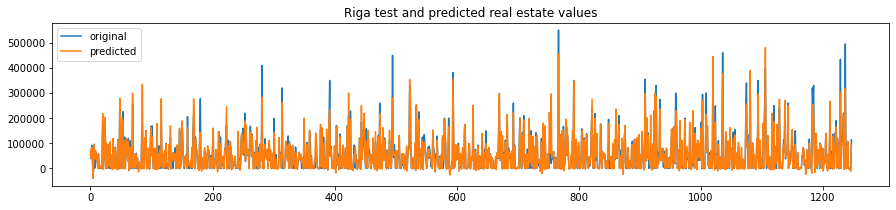

In [25]:
from matplotlib.pyplot import figure
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 3, forward=True)

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, xgbr_predictions, label="predicted")
plt.title("Riga test and predicted real estate values")
plt.legend()
plt.show()